# Laboratorio 08 - Modelo de ML
Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

## Parte 01, Selección de modelos
### a) Exploración de los datos

In [2]:
data_path = "../data/houses_to_rent_v2.csv"
data = pd.read_csv(data_path)

info = data.info()
head = data.head()

info, head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


(None,
            city  area  rooms  bathroom  parking spaces floor     animal  \
 0     São Paulo    70      2         1               1     7      acept   
 1     São Paulo   320      4         4               0    20      acept   
 2  Porto Alegre    80      1         1               1     6      acept   
 3  Porto Alegre    51      2         1               0     2      acept   
 4     São Paulo    25      1         1               0     1  not acept   
 
        furniture  hoa (R$)  rent amount (R$)  property tax (R$)  \
 0      furnished      2065              3300                211   
 1  not furnished      1200              4960               1750   
 2  not furnished      1000              2800                  0   
 3  not furnished       270              1112                 22   
 4  not furnished         0               800                 25   
 
    fire insurance (R$)  total (R$)  
 0                   42        5618  
 1                   63        7973  
 2         

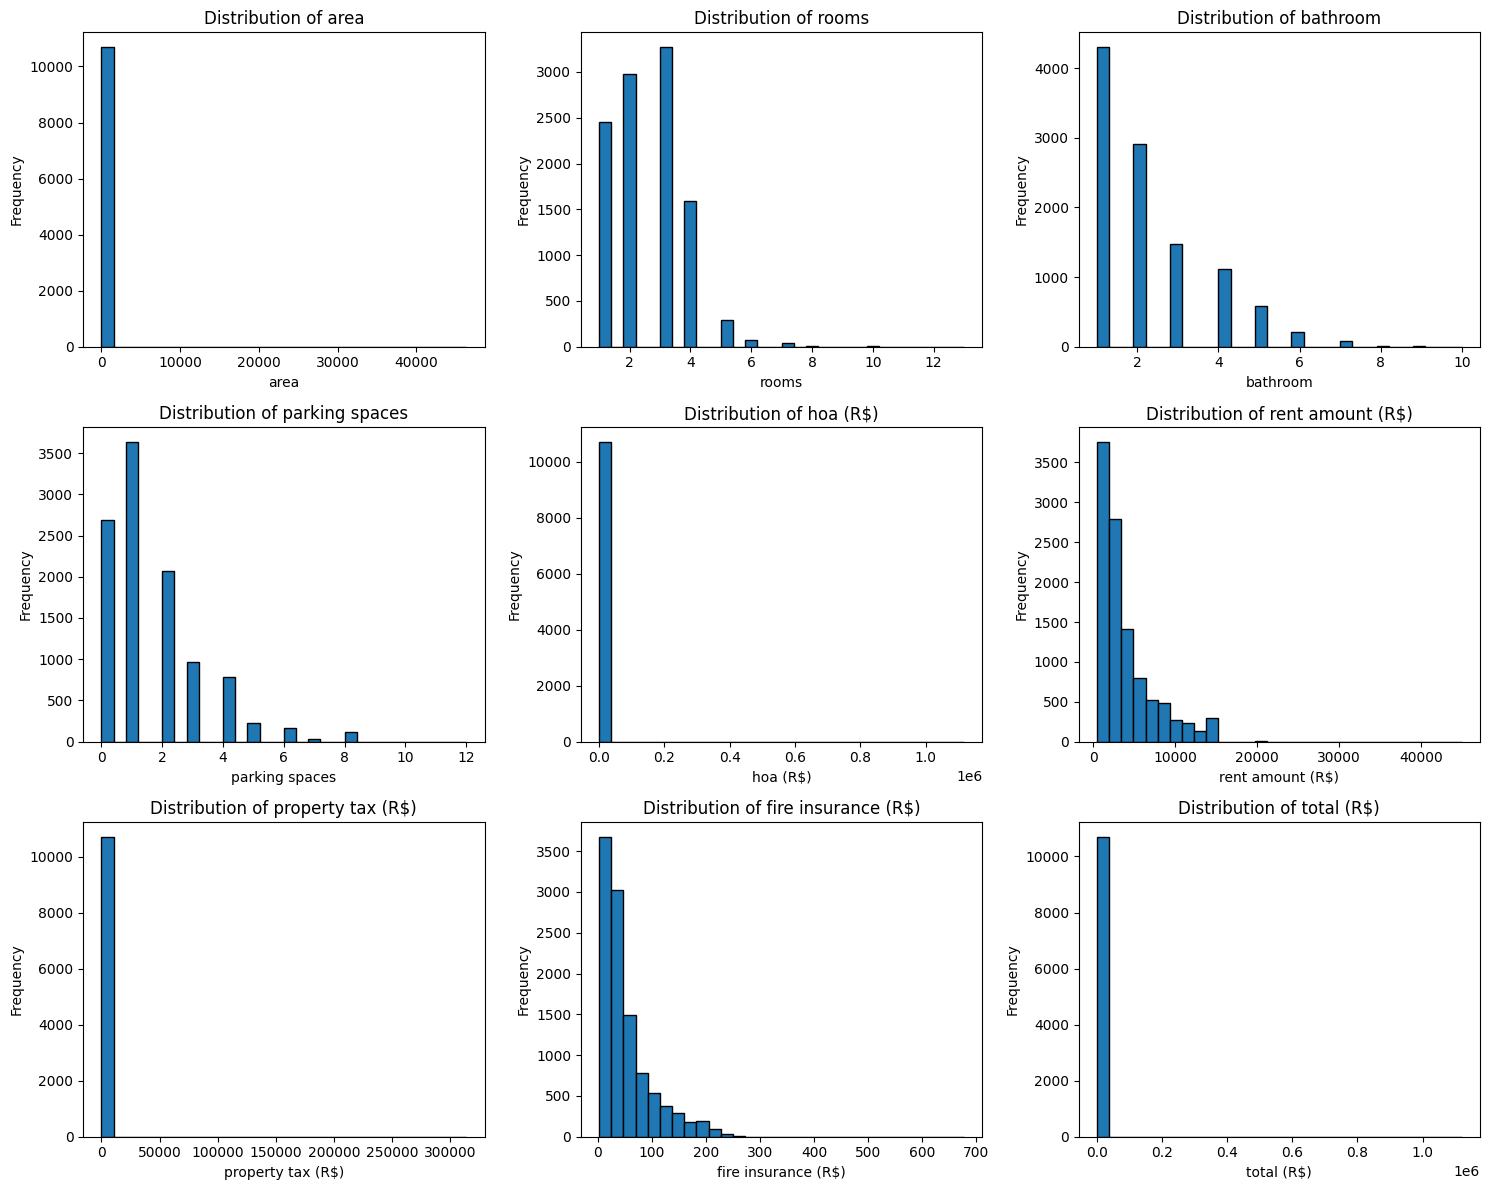

In [3]:
# análisis de columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])
numeric_columns = numeric_data.columns

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(numeric_columns):
    axs[i].hist(data[col], bins=30, edgecolor='black')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

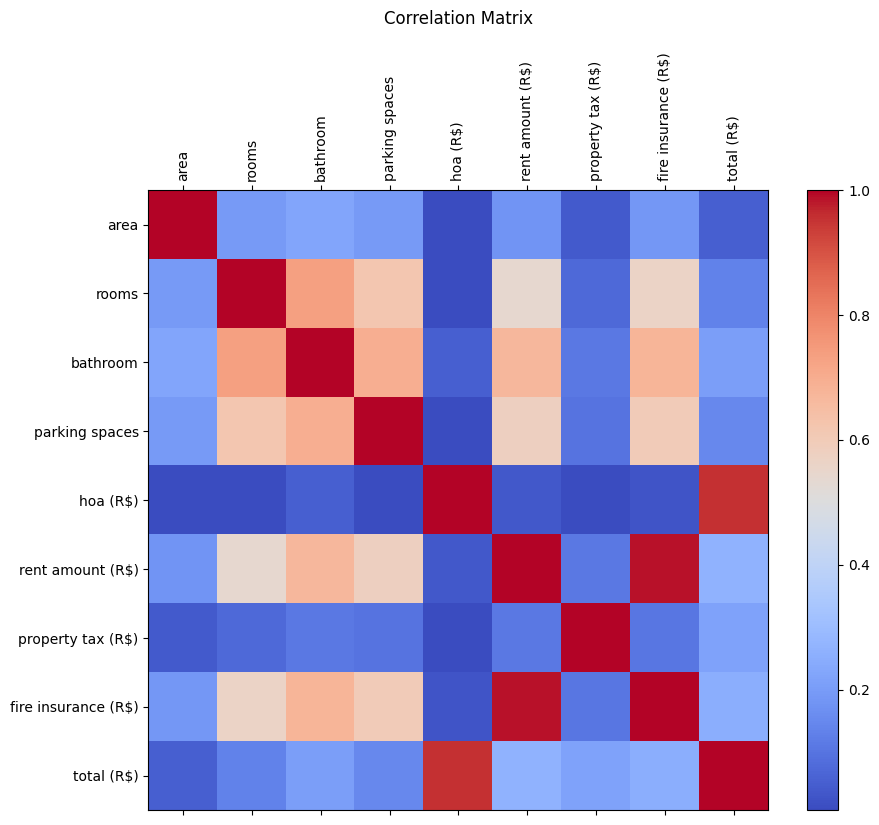

In [4]:
# matriz de correlación
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.title("Correlation Matrix", pad=20)
plt.show()

Entre los hallazgos principales dentro del análisis exploratorio se encuentran las distribuciones de las columnas numéricas:
- Las distribuciones de área y habitaciones están sesgadas hacia la derecha, lo que indica una mayor cantidad de propiedades más pequeñas.
- La HOA (R$), el monto del alquiler (R$) y el total (R$) muestran algunos valores atípicos en los rangos más altos.
- El impuesto a la propiedad y el seguro contra incendios tienen valores bajos para muchas propiedades, con una porción significativa en cero, lo que sugiere que estos costos pueden no aplicarse siempre.

Por otro lado, en la matriz de correlación se encontró:
- El total (R$) está altamente correlacionado con la HOA (R$), lo que tiene sentido ya que el alquiler total incluye esta tarifa.
- El monto del alquiler (R$) tiene una fuerte correlación positiva con el seguro contra incendios (R$) y una correlación moderada con el baño y los espacios de estacionamiento.
- Las habitaciones y el baño también están fuertemente correlacionados, lo que indica que las propiedades más grandes suelen tener más habitaciones y baños.
- Otras correlaciones, como el área con otras características, son relativamente débiles, lo que sugiere que el área por sí sola puede no ser el predictor más fuerte del precio del alquiler en este conjunto de datos.

En base a esto, los predictores más relevantes para el monto del alquiler parecen ser características como el baño, los espacios de estacionamiento y las habitaciones.

### b) Preprocesamiento y limpieza de datos

In [5]:
# desde el inicio no se encontraron valores nulos o faltantes en el dataset
# valores atípicos
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Cap outliers for numerical columns
df_capped = cap_outliers(data.copy(), numeric_columns)

In [6]:
# codificación de variables categoricas
categorical_columns = ['city', 'animal', 'furniture', 'floor']
df_capped_encoded = pd.get_dummies(df_capped, columns=categorical_columns, drop_first=True)

In [7]:
# normalización de variables numéricas
scaler = MinMaxScaler()

df_capped_encoded[numeric_columns] = scaler.fit_transform(df_capped_encoded[numeric_columns])

df_capped_encoded.head()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_Campinas,...,floor_32,floor_35,floor_4,floor_46,floor_5,floor_51,floor_6,floor_7,floor_8,floor_9
0,0.163889,0.285714,0.0,0.2,0.727433,0.292158,0.239637,0.287823,0.384068,False,...,False,False,False,False,False,False,False,True,False,False
1,0.858333,0.857143,0.6,0.0,0.422721,0.462327,1.000000,0.442804,0.560759,False,...,False,False,False,False,False,False,False,False,False,False
2,0.191667,0.000000,0.0,0.2,0.352268,0.240902,0.000000,0.280443,0.250743,False,...,False,False,False,False,False,False,True,False,False,False
3,0.111111,0.285714,0.0,0.0,0.095112,0.067863,0.024986,0.103321,0.069176,False,...,False,False,False,False,False,False,False,False,False,False
4,0.038889,0.000000,0.0,0.0,0.000000,0.035879,0.028393,0.059041,0.025284,False,...,False,False,False,False,False,False,False,False,False,False


### c) Entrenamiento y selección de modelos
Se han seleccionado los modelos Regresión Lineal, Random Forest y Gradient Boosting por su simplicidad y robustez para poder capturar los patrones que se han explorado en los datos.

In [8]:
# separación de los datos
X = df_capped_encoded.drop(columns=['rent amount (R$)'])
y = df_capped_encoded['rent amount (R$)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# modelos
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(random_state=42)
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

In [10]:
# regresión lineal
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = root_mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print ("(1) Regresión Lineal")
print(f"RMSE: {rmse_linear}")
print(f"MAE: {mae_linear}")
print(f"R²: {r2_linear}")

(1) Regresión Lineal
RMSE: 0.022764077275915038
MAE: 0.01233904109268299
R²: 0.9935543381720363


In [11]:
# random forest
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print ("(2) Random Forest")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")
print(f"R²: {r2_rf}")

(2) Random Forest
RMSE: 0.017685894978712056
MAE: 0.0051418987326379865
R²: 0.9961093559674401


In [12]:
# gradient boosting
gradient_boosting_model.fit(X_train, y_train)
y_pred_gb = gradient_boosting_model.predict(X_test)
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print ("(3) Gradient Boosting")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")
print(f"R²: {r2_gb}")

(3) Gradient Boosting
RMSE: 0.018064297542613232
MAE: 0.008799115161616779
R²: 0.9959410886119724


### d) Interpretación de resultados
- El modelo de **regresión lineal** tiene un buen ajuste y un R² alto. Por otro lado, el RMSE y el MAE son los más altos entre los demás modelos. Esto significa que no captura del todo bien las relaciones más complejas entre variables.
- El modelo **random forest** es el que presenta mejores resultados, porque tiene el menor RMSE y MAE. Su R² es el más alto. Lo que indica que es el que tiene mejor desempeño predictivo y captura mejor las variaciones de los datos.
- El modelo **gradient boosting tree** también tiene un R² alto, pero tiene mayor RMSE y MAE en comparación con RF.

Al considerar `Random Forest` como el mejor modelo de los tres, se pueden destacar las siguientes fortalezas y debilidades:
- Fortalezas:
    - Maneja mejor los datos no lineales.
    - Es menos sensible hacia los valores atípicos a pesar de haber realizado el preprocesamiento.
    - Generaliza bien los conjuntos de datos con muchas características.

- Debilidades:
    - Utiliza más recursos y puede ser más tardado.
    - Puede llegar a tener sobreajuste.